In [8]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras import layers, models

# Paths to datasets and images
image_folder = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\Panda Express images'
excel_file = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\PandaExpress.xlsx'
train_dir = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\data\train'
validation_dir = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\data\validation'

# Load the Excel dataset
data = pd.read_excel(excel_file, sheet_name='Sheet1')
data['Formatted Dish Name'] = data['Dish Name'].str.replace(' ', '_').str.strip().str.lower()

# Create a mapping list
mapping = []
for file in os.listdir(image_folder):
    if file.lower().endswith(('.png', '.jpg', '.jpeg', '.webp', '.gif')):
        dish_name = os.path.splitext(file)[0].rsplit('_', 1)[0].lower()
        dish_row = data[data['Formatted Dish Name'] == dish_name]
        if dish_row.empty:
            dish_row = data[data['Formatted Dish Name'].str.contains(dish_name)]
        if not dish_row.empty:
            mapping.append({
                'Image Filename': file,
                'Dish Name': dish_row.iloc[0]['Dish Name'],
                'Calories': dish_row.iloc[0]['Calories'],
                'Category': dish_row.iloc[0]['Category']
            })
        else:
            print(f"No match found for: {file} (Parsed dish name: {dish_name})")

# Save the mapping table
mapping_df = pd.DataFrame(mapping)
mapping_csv_path = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\ImageDishMapping.csv'
mapping_df.to_csv(mapping_csv_path, index=False)
print(f"Mapping table saved to {mapping_csv_path}")

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, target_size=(224, 224), batch_size=32, class_mode='categorical'
)

# Load and fine-tune MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Save the model in the new Keras format
model.save('pretrained_panda_express_model.keras')

# Prediction function with confidence threshold
# def predict_dish(image_path, threshold=0.5):
#     img = load_img(image_path, target_size=(224, 224))
#     img_array = img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     prediction = model.predict(img_array)
#     class_idx = np.argmax(prediction)
#     confidence = prediction[0][class_idx]

#     class_labels = {v: k for k, v in train_generator.class_indices.items()}
#     if confidence < threshold:
#         return "Uncertain Prediction", confidence
#     return class_labels[class_idx], confidence

Mapping table saved to C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\ImageDishMapping.csv
Found 25 images belonging to 5 classes.
Found 9 images belonging to 5 classes.


C:\Users\anamt\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.1200 - loss: 2.3172 - val_accuracy: 0.3333 - val_loss: 1.4159
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2800 - loss: 1.5796 - val_accuracy: 0.3333 - val_loss: 1.4003
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5600 - loss: 1.1132 - val_accuracy: 0.4444 - val_loss: 1.3876
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5200 - loss: 1.3899 - val_accuracy: 0.4444 - val_loss: 1.3441
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6800 - loss: 0.7925 - val_accuracy: 0.6667 - val_loss: 1.2101
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6800 - loss: 0.6962 - val_accuracy: 0.6667 - val_loss: 1.0438
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8800 - loss: 0.3652 - val_accuracy: 0.6667 - val_loss: 0.8700
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9600 - loss: 0.2816 - val_accuracy: 0.6667 - val_loss: 0.7086
Epoch 9/10
1/1 ━

In [32]:
def predict_dish_with_details(image_path, threshold=0.5):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Get model predictions
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    confidence = prediction[0][class_idx]

    # Map predictions to class labels
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_dish = class_labels[class_idx]

    # If confidence is below the threshold, return uncertain prediction
    if confidence < threshold:
        return {
            "Predicted Dish": "Uncertain Prediction",
            "Calories": None,
            "Category": None,
            "Confidence": confidence
        }
    
    formatted_dish = predicted_dish.replace(' ', '_').strip().lower()
#     formatted_dish = f"_{predicted_dish.replace(' ', '_').strip().lower()}"

    # Retrieve additional details (Calories and Category) from the Excel dataset
    dish_row = data[data['Formatted Dish Name'] == formatted_dish]
    if not dish_row.empty:
        dish_name = dish_row.iloc[0]['Dish Name']
        calories = dish_row.iloc[0]['Calories']
        category = dish_row.iloc[0]['Category']
    else:
        # Fallback if no matching dish is found
        dish_name = predicted_dish.replace('_', ' ').title()
        calories = "Unknown"
        category = "Unknown"
    
    print(f"Predicted Dish: {predicted_dish}")
    print(f"Formatted Predicted Dish: {formatted_dish}")
#     print(f"Dataset Formatted Names: {data['Formatted Dish Name'].tolist()}")
    
    # Return the prediction details
    return {
        "Predicted Dish": dish_name,
        "Calories": calories,
        "Category": category,
        "Confidence": confidence
    }


# Example usage
test_image_path = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\Menu Photos\Panda Express\test0.jpg'
# dish_name, confidence = predict_dish(test_image_path)
# print(f"Predicted dish: {dish_name} with confidence {confidence:.2f}")

result = predict_dish_with_details(test_image_path)

print(f"Predicted Dish: {result['Predicted Dish']}")
print(f"Calories: {result['Calories']}")
print(f"Category: {result['Category']}")
print(f"Confidence: {result['Confidence']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Dish: Super_Greens
Formatted Predicted Dish: super_greens
Predicted Dish: Super Greens
Calories: 90
Category: Healthy
Confidence: 0.70


In [33]:
test_image_path = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\Menu Photos\Panda Express\test5.jpg'
# dish_name, confidence = predict_dish(test_image_path)
# print(f"Predicted dish: {dish_name} with confidence {confidence:.2f}")

result = predict_dish_with_details(test_image_path)

print(f"Predicted Dish: {result['Predicted Dish']}")
print(f"Calories: {result['Calories']}")
print(f"Category: {result['Category']}")
print(f"Confidence: {result['Confidence']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Dish: Broccoli_Beef
Formatted Predicted Dish: broccoli_beef
Predicted Dish: Broccoli Beef
Calories: Unknown
Category: Unknown
Confidence: 0.94


In [18]:
test_image_path = r'C:\Users\anamt\OneDrive - Cal State Fullerton\RA\AI Food Project\Menu Photos\Panda Express\test1.jpg'
# dish_name, confidence = predict_dish(test_image_path)
# print(f"Predicted dish: {dish_name} with confidence {confidence:.2f}")

result = predict_dish_with_details(test_image_path)

print(f"Predicted Dish: {result['Predicted Dish']}")
print(f"Calories: {result['Calories']}")
print(f"Category: {result['Category']}")
print(f"Confidence: {result['Confidence']:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Predicted Dish: Uncertain Prediction
Calories: None
Category: None
Confidence: 0.39


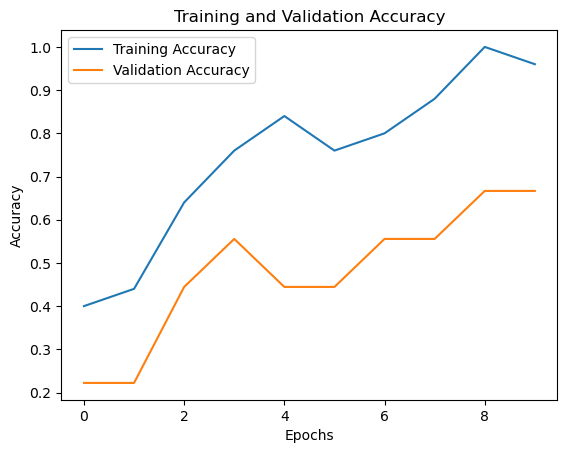

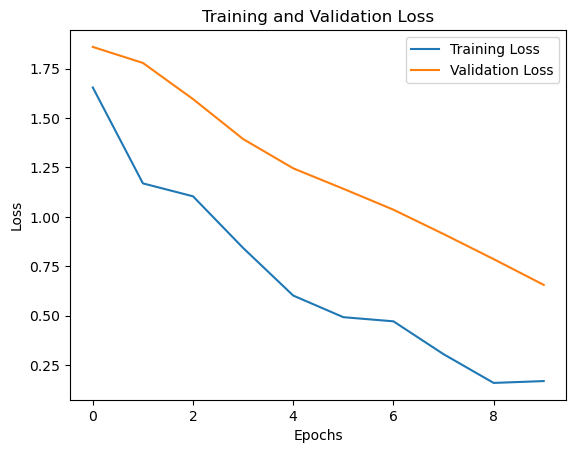

In [5]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()